In [1]:
import numpy as np
import mne
from scipy.signal import hilbert
from mne.stats import permutation_cluster_test
from statsmodels.stats.multitest import fdrcorrection
from src.utils.logger import create_logger
from src.utils.data import load_yaml

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def analyze_impedances(bids_root_path):
    """
    Step 1: Extracts electrode impedances from BIDS electrodes.tsv files
    and plots the distribution.
    """
    bids_root = Path(bids_root_path)
    
    # 1. Find all electrodes.tsv files recursively in the BIDS directory
    # BIDS naming convention ends in _electrodes.tsv
    electrode_files = list(bids_root.rglob('/home/owaismujtaba/projects/mind-voice/BIDS/*electrodes.tsv'))
    
    if not electrode_files:
        print("No electrodes.tsv files found. Check your BIDS root path.")
        return

    print(f"Found {len(electrode_files)} electrode files.")

    all_impedances = []

    # 2. Iterate through files and extract data
    for file_path in electrode_files:
        try:
            # Read tsv file
            df = pd.read_csv(file_path, sep='\t')
            
            # Check if 'impedance' column exists (Standard BIDS column)
            if 'impedance' in df.columns:
                # BIDS uses 'n/a' for missing values; force conversion to numeric
                # errors='coerce' turns non-numeric strings (like 'n/a') into NaN
                impedances = pd.to_numeric(df['impedance'], errors='coerce')
                
                # Drop NaNs (channels with no recorded impedance)
                impedances = impedances.dropna()
                
                # Extract metadata from filename (subject/session) for granularity
                # Filename format usually: sub-01_ses-01_task-rest_electrodes.tsv
                filename_parts = file_path.name.split('_')
                sub = next((s for s in filename_parts if 'sub-' in s), 'unknown')
                ses = next((s for s in filename_parts if 'ses-' in s), 'unknown')
                
                # Store data
                for val in impedances:
                    all_impedances.append({
                        'subject': sub,
                        'session': ses,
                        'impedance': val,
                        'file': file_path.name
                    })
            else:
                print(f"Warning: 'impedance' column missing in {file_path.name}")
                
        except Exception as e:
            print(f"Error reading {file_path.name}: {e}")

    # Convert to DataFrame for analysis
    img_df = pd.DataFrame(all_impedances)

    if img_df.empty:
        print("No valid impedance data found in the files.")
        return

    # --- 3. Statistical Summary ---
    print("\n--- Step 1: Impedance Statistics ---")
    print(img_df['impedance'].describe())
    
    # --- 4. Visualization (Distribution) ---
    plt.figure(figsize=(10, 6))
    
    # Create a histogram with a kernel density estimate (KDE)
    sns.histplot(data=img_df, x='impedance', kde=True, bins=30, color='skyblue')
    
    # Add lines for mean and common thresholds (e.g., 5, 10, 20 kOhm)
    plt.axvline(img_df['impedance'].mean(), color='red', linestyle='--', label=f"Mean: {img_df['impedance'].mean():.2f}")
    plt.axvline(img_df['impedance'].median(), color='green', linestyle='-', label=f"Median: {img_df['impedance'].median():.2f}")
    
    plt.title('Distribution of Electrode Impedances (Start of Recording)')
    plt.xlabel('Impedance (kOhm)') # Assuming standard kOhm units
    plt.ylabel('Count (Electrodes)')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    return img_df

# --- Usage ---
# Replace this path with the actual path to your BIDS dataset
path_to_bids = "'BIDS/" 

# Run the function
df_impedances = analyze_impedances(path_to_bids)

NotImplementedError: Non-relative patterns are unsupported

In [4]:
data = pd.read_csv('/home/owaismujtaba/projects/mind-voice/BIDS/sub-02/ses-01/eeg/sub-02_ses-01_space-CapTrak_electrodes.tsv', delimiter='\t')

Found 15 electrode files.


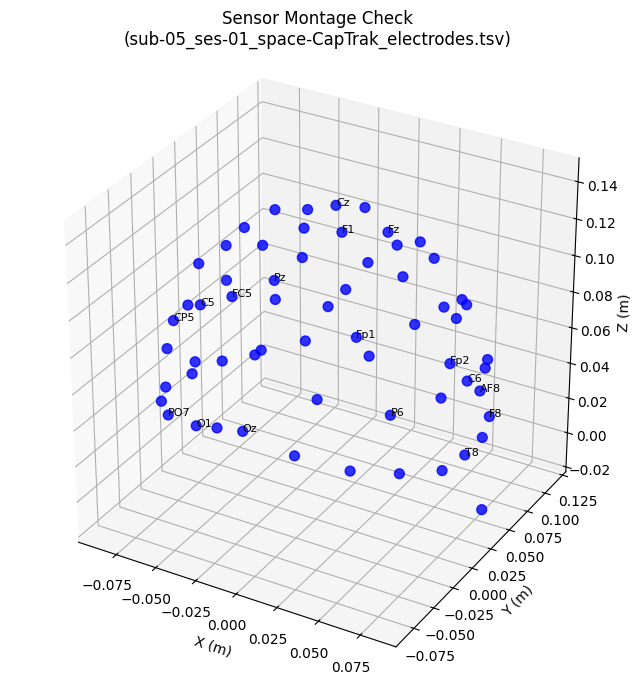

Visualization complete.

--- Checking Coordinate Integrity for all subjects ---
 - sub-05_ses-01_space-CapTrak_electrodes.tsv
 - sub-10_ses-01_space-CapTrak_electrodes.tsv
 - sub-12_ses-01_space-CapTrak_electrodes.tsv
 - sub-03_ses-01_space-CapTrak_electrodes.tsv
 - sub-09_ses-01_space-CapTrak_electrodes.tsv
 ... and others.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def check_electrode_coordinates(bids_root_path):
    """
    Alternative to Step 1: Since impedance is missing, this function 
    visualizes the 3D coordinates (x, y, z) to verify sensor geometry.
    """
    bids_root = Path(bids_root_path)
    
    # 1. Find all electrodes.tsv files
    electrode_files = list(bids_root.rglob('*_electrodes.tsv'))
    
    if not electrode_files:
        print("No electrodes.tsv files found.")
        return

    print(f"Found {len(electrode_files)} electrode files.")

    # We will plot the first file found to visualize the montage
    # and check the rest for missing coordinate data
    sample_file = electrode_files[0]
    
    try:
        # Read the sample file
        df = pd.read_csv(sample_file, sep='\t')
        
        # Check for coordinate columns (BIDS standard: x, y, z)
        coord_cols = ['x', 'y', 'z']
        if all(col in df.columns for col in coord_cols):
            
            # --- Visualization ---
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            
            xs = df['x']
            ys = df['y']
            zs = df['z']
            names = df['name'] if 'name' in df.columns else df.index

            # Plot sensors
            ax.scatter(xs, ys, zs, c='b', marker='o', s=50, alpha=0.8)
            
            # Label a few sensors to help orientation (e.g., midline)
            for i, name in enumerate(names):
                # Only label 10% of electrodes to avoid clutter, or specific ones like Cz
                if name in ['Cz', 'Fz', 'Pz', 'Oz', 'Fp1', 'Fp2'] or i % 5 == 0:
                    ax.text(xs[i], ys[i], zs[i], str(name), fontsize=8)

            ax.set_title(f'Sensor Montage Check\n({sample_file.name})')
            ax.set_xlabel('X (m)')
            ax.set_ylabel('Y (m)')
            ax.set_zlabel('Z (m)')
            
            # Try to equalize aspect ratio for 3D plot
            ax.set_box_aspect([1,1,1]) 
            
            plt.show()
            print("Visualization complete.")

        else:
            print(f"Error: {sample_file.name} is missing x, y, or z columns.")

    except Exception as e:
        print(f"Error reading {sample_file.name}: {e}")

    # --- Integrity Check for all files ---
    print("\n--- Checking Coordinate Integrity for all subjects ---")
    files_with_missing_coords = []
    
    for file_path in electrode_files:
        df_check = pd.read_csv(file_path, sep='\t')
        # Check if x, y, z exist and are not NaN
        if not all(col in df_check.columns for col in coord_cols) or df_check[coord_cols].isnull().values.any():
            files_with_missing_coords.append(file_path.name)

    if files_with_missing_coords:
        print(f"WARNING: The following {len(files_with_missing_coords)} files have missing coordinates:")
        for f in files_with_missing_coords[:5]: print(f" - {f}")
        if len(files_with_missing_coords) > 5: print(" ... and others.")
    else:
        print("SUCCESS: All detected electrode files contain valid x, y, z coordinates.")

# --- Usage ---
path_to_bids = "BIDS"
check_electrode_coordinates(path_to_bids)

In [42]:
import numpy as np
import mne

def compute_snr_p100(epochs, picks=['PO3', 'POz', 'PO4'],
                     baseline_window=(-0.2, 0.0),
                     signal_window=(0.08, 0.12)):
    """
    Compute SNR in dB using variance ratio between post-stimulus P100 window
    and pre-stimulus baseline window.
    """

    # Pick occipital electrodes
    data = epochs.copy().pick_channels(picks).get_data()  # shape: (n_epochs, n_channels, n_times)
    sfreq = epochs.info['sfreq']

    # Time indices
    times = epochs.times
    base_idx = np.where((times >= baseline_window[0]) & (times <= baseline_window[1]))[0]
    sig_idx = np.where((times >= signal_window[0]) & (times <= signal_window[1]))[0]

    # Extract baseline and signal segments
    baseline_data = data[:, :, base_idx]  # (epochs, channels, time)
    signal_data = data[:, :, sig_idx]

    # Variance across time within each epoch/channel, then average
    baseline_var = np.var(baseline_data, axis=2).mean()
    signal_var   = np.var(signal_data, axis=2).mean()

    # SNR in dB
    snr_db = 10 * np.log10(signal_var / baseline_var)

    return snr_db



In [11]:
from src.dataset.data_reader import BIDSDatasetReader
from src.dataset.eeg_epoch_builder import EEGEpochBuilder
from src.utils.logger import create_logger
from src.utils.data import load_yaml

In [12]:
config = 'config.yaml'
config = load_yaml(config)
logger = create_logger('test')


In [13]:
reader = BIDSDatasetReader(
    logger=logger, config=config, subject='01', session='01'
)

[2025-11-27 12:49:19] [INFO] ************************************************************
[2025-11-27 12:49:19] [INFO] **********Initializing BIDSDatasetReader**********
[2025-11-27 12:49:19] [INFO] ************************************************************


In [15]:
reader._load_raw()
eeg = reader.raw_eeg

[2025-11-27 12:50:05] [INFO] Loading raw EEG data


Reading 0 ... 6306999  =      0.000 ...  6306.999 secs...


/home/owaismujtaba/projects/mind-voice/src/dataset/data_reader.py:44: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['EOG1', 'EOG2']
  self.raw_eeg = read_raw_bids(self.bidspath, verbose=False)
[2025-11-27 12:50:13] [INFO] Data read sucessfully


In [33]:
visual = EEGEpochBuilder(
    eeg_data=eeg,
    trial_mode='', trial_unit='Words',
    trial_boundary='Start', 
    experiment_mode='Experiment', 
    trial_type='Speech',
    modality='Picture',
    logger=logger
)

rest = EEGEpochBuilder(
    eeg_data=eeg,
    trial_mode='', trial_unit='Words',
    trial_boundary='Start', 
    experiment_mode='Experiment', 
    trial_type='Fixation',
    modality='',
    logger=logger
)

[2025-11-27 12:56:12] [INFO] ************************************************************
[2025-11-27 12:56:12] [INFO] **********Initializing Epoch Builder**********
[2025-11-27 12:56:12] [INFO] ************************************************************
[2025-11-27 12:56:12] [INFO] ************************************************************
[2025-11-27 12:56:12] [INFO] **********Initializing Epoch Builder**********
[2025-11-27 12:56:12] [INFO] ************************************************************


In [34]:
visual_epochs = visual.create_epochs(tmin=-0.2, tmax=0.5)
rest_epochs = rest.create_epochs(tmin=-0.2, tmax=0.5)

[2025-11-27 12:56:13] [INFO] Creating Epochs


        Extraction Criteria        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Parameter          ┃ Value      ┃
┣━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ 🧪 Trial Mode      ┃            ┃
┃ 📏 Trial Unit      ┃ Words      ┃
┃ 🔗 Experiment Mode ┃ Experiment ┃
┃ 🎭 Trial Boundary  ┃ Start      ┃
┃ 🔬 Trial Type      ┃ Speech     ┃
┃ 📊 Modality        ┃ Picture    ┃
┃ ⏱ Tmin             ┃ -0.2       ┃
┃ ⏳ Tmax            ┃ 0.5        ┃
┗━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━┛

Not setting metadata
130 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 130 events and 701 original time points ...
0 bad epochs dropped


[2025-11-27 12:56:13] [INFO] Creating Epochs


        Extraction Criteria        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Parameter          ┃ Value      ┃
┣━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ 🧪 Trial Mode      ┃            ┃
┃ 📏 Trial Unit      ┃ Words      ┃
┃ 🔗 Experiment Mode ┃ Experiment ┃
┃ 🎭 Trial Boundary  ┃ Start      ┃
┃ 🔬 Trial Type      ┃ Fixation   ┃
┃ 📊 Modality        ┃            ┃
┃ ⏱ Tmin             ┃ -0.2       ┃
┃ ⏳ Tmax            ┃ 0.5        ┃
┗━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━┛

Not setting metadata
510 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 510 events and 701 original time points ...
0 bad epochs dropped


In [36]:
visual_epochs.get_data().shape

(130, 64, 701)

In [51]:
occipital = ['PO3', 'POz', 'PO4']

In [52]:
visual_epochs = visual_epochs.pick(occipital)
rest_epochs = rest_epochs.pick(occipital)

In [53]:
import numpy as np
import mne

def snr_on_evoked(epochs, picks=None,
                  baseline_window=(-0.2, 0.0),
                  signal_window=(0.08, 0.500),
                  to_uV=True):
    """
    Compute SNR (linear and dB) using the averaged evoked (ERP).
    - epochs: mne.Epochs (cleaned, baseline corrected recommended)
    - picks: list of channel names or None for all EEG channels
    """
    if picks is not None:
        picks = [ch for ch in picks if ch in epochs.ch_names]
        evoked = epochs.copy().pick_channels(picks).average()
    else:
        evoked = epochs.average()

    # ensure baseline correction applied to evoked: subtract baseline mean
    times = evoked.times
    base_idx = np.where((times >= baseline_window[0]) & (times <= baseline_window[1]))[0]
    sig_idx  = np.where((times >= signal_window[0]) & (times <= signal_window[1]))[0]
    if len(base_idx) == 0 or len(sig_idx) == 0:
        raise ValueError("Check windows vs evoked.times")

    data = evoked.data.copy()  # shape (n_channels, n_times)
    # baseline-correct the evoked if not already
    data = data - data[:, base_idx].mean(axis=1, keepdims=True)

    if to_uV:
        data = data * 1e6

    # variance across time in each window (on the averaged ERP)
    baseline_var_chan = np.var(data[:, base_idx], axis=1)
    signal_var_chan   = np.var(data[:, sig_idx], axis=1)

    snr_chan_linear = signal_var_chan / baseline_var_chan
    snr_chan_db     = 10 * np.log10(snr_chan_linear)

    # overall pooled across channels (mean of channel variances)
    snr_overall_linear = signal_var_chan.mean() / baseline_var_chan.mean()
    snr_overall_db     = 10 * np.log10(snr_overall_linear)

    return {
        'channel_names': evoked.ch_names,
        'snr_chan_linear': snr_chan_linear,
        'snr_chan_db': snr_chan_db,
        'snr_overall_linear': snr_overall_linear,
        'snr_overall_db': snr_overall_db,
        'baseline_var_chan': baseline_var_chan,
        'signal_var_chan': signal_var_chan,
    }

def snr_rms_evoked(epochs, picks=None,
                   baseline_window=(-0.2, 0.0),
                   signal_window=(0.08, 0.12),
                   to_uV=True):
    """
    Compute SNR using RMS (root-mean-square) of the averaged evoked:
      SNR_RMS = 10 * log10( (RMS_signal^2) / (RMS_baseline^2) )
    Equivalent to variance ratio but RMS emphasizes amplitude magnitude.
    """
    out = snr_on_evoked(epochs, picks=picks,
                        baseline_window=baseline_window,
                        signal_window=signal_window,
                        to_uV=to_uV)
    # For clarity return RMS-derived SNR as well
    baseline_rms = np.sqrt(out['baseline_var_chan'])
    signal_rms   = np.sqrt(out['signal_var_chan'])
    snr_rms_lin  = (signal_rms**2) / (baseline_rms**2)  # same as var ratio
    snr_rms_db   = 10 * np.log10(snr_rms_lin)

    out.update({'snr_rms_chan_db': snr_rms_db, 'snr_rms_chan_linear': snr_rms_lin})
    return out


In [55]:
snr_on_evoked(visual_epochs, picks=occipital)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


{'channel_names': ['PO3', 'POz', 'PO4'],
 'snr_chan_linear': array([8.8990171 , 8.76883729, 7.34155409]),
 'snr_chan_db': array([9.49342041, 9.42942012, 8.65788003]),
 'snr_overall_linear': np.float64(8.351421834158026),
 'snr_overall_db': np.float64(9.217604206526584),
 'baseline_var_chan': array([11.9660318 , 11.65244746, 11.30490006]),
 'signal_var_chan': array([106.48592155, 102.17841583,  82.99553519])}

In [56]:
snr_on_evoked(rest_epochs, picks=occipital)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


{'channel_names': ['PO3', 'POz', 'PO4'],
 'snr_chan_linear': array([1.73412144, 1.64542171, 2.18742894]),
 'snr_chan_db': array([2.39079507, 2.16277223, 3.39933953]),
 'snr_overall_linear': np.float64(1.8597769759479676),
 'snr_overall_db': np.float64(2.694608668402285),
 'baseline_var_chan': array([4.84416459, 4.9679985 , 5.1078979 ]),
 'signal_var_chan': array([ 8.40036966,  8.17445259, 11.17316366])}